<a href="https://colab.research.google.com/github/psych0man/Image-Classification-using-Augementation/blob/master/Image_Classification_using_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# Importing Packages

![alt text](https://upload.wikimedia.org/wikipedia/commons/1/11/TensorFlowLogo.svg)

We only need 3 packages for building this model:


1.   **[os](https://docs.python.org/3/library/os.html):** for handling directories
2.   **[Random](https://docs.python.org/3/library/random.html):** used in the splitting function to have a random shuffle of images
3.   **[TensorFlow](https://github.com/tensorflow/tensorflow):** The main framework used for building the Convolutional Neural Network

We'll also need the [RMSprop](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) optimizer from the tensorflow.keras.optimizers and the main focus of our project which is [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) from tensorflow.keras.preprocessing.image


In [ ]:
import os
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extracting Data from the Zip File

The dataset for this project was obtained from the classic kaggle [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview) . Use this [link](https://www.kaggle.com/c/dogs-vs-cats/data) to go to the website and download the dataset for yourself.

The Dataset was in a zipfile so the zipfile package was used to extract the files.

In [ ]:
from zipfile import ZipFile 

file_name = "/content/Dataset.zip"
  
with ZipFile(file_name, 'r') as zip: 
    zip.printdir() 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

# Making Directories

We're going to make two main directories using [os.makedir() ](https://docs.python.org/3/library/os.html). These two directories will further contain two directories each named "**cats**" and "**dogs**"

In [ ]:
to_create = [
    '/content/cats-v-dogs',
    '/content/cats-v-dogs/training',
    '/content/cats-v-dogs/testing',
    '/content/cats-v-dogs/training/cats',
    '/content/cats-v-dogs/training/dogs',
    '/content/cats-v-dogs/testing/cats',
    '/content/cats-v-dogs/testing/dogs'
]

for directory in to_create:
    try:
        os.mkdir(directory)
        print(directory, 'created')
    except:
        print(directory, 'failed')

# Splitting the Data

In the following code cell we're going to make a function to split the data into a training and testing dataset having the split size as a parameter

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)


CAT_SOURCE_DIR = "/content/PetImages/Cat/"
TRAINING_CATS_DIR = "/content/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/content/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/content/PetImages/Dog/"
TRAINING_DOGS_DIR = "/content/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/content/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Building the Model

We're going to use a simple model architecture with **3 [Convolution Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)** with **[MaxPooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)** and **2 [Dense Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)** followed by a final output layer.

I've used the **[RMSprop](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop)** optimizer ( with a custom learning rate of 0.001 ). For the loss function **[Binary Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)** was best suited as it is a binary classification problem. 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(150, 150, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

# Augmentation in ImageDataGenerator

I've only used a few parameters of the ImageDataGenerator function. For the complete list visit the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
TRAINING_DIR = '/content/cats-v-dogs/training'
train_datagen = ImageDataGenerator(
    rescale=1 / 255, # Rescaling for Normalization
    rotation_range=40, # integer range for random rotations
    width_shift_range=.2, # Fraction of the range to shift width-wise
    height_shift_range=.2, # Fraction of the range to shift height-wise
    shear_range=.2, # Fraction for Shear Intensity
    zoom_range=.2, # Fraction for random zoom
    horizontal_flip=True, # Allowing for Flipped Images
    fill_mode='nearest' # 'nearest' is the default fill mode 
)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=64,
    class_mode='binary', # 'binary' because we have only two classes
    target_size=(150, 150)
)

VALIDATION_DIR = '/content/cats-v-dogs/testing'
validation_datagen = ImageDataGenerator(
    rescale=1 / 255, # Rescaling for Normalization
    rotation_range=40, # integer range for random rotations
    width_shift_range=.2, # Fraction of the range to shift width-wise
    height_shift_range=.2, # Fraction of the range to shift height-wise
    shear_range=.2, # Fraction for Shear Intensity
    zoom_range=.2, # Fraction for random zoom
    horizontal_flip=True, # Allowing for Flipped Images
    fill_mode='nearest' # 'nearest' is the default fill mode 

)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=64,
    class_mode='binary', # 'binary' because we have only two classes
    target_size=(150, 150)
)

# Training the Model

In [ ]:
history = model.fit_generator(train_generator,
                              epochs=2,
                              verbose=1,
                              validation_data=validation_generator)

# Analysing the Model by Graphs

Text(0.5, 1.0, 'Training and validation loss')

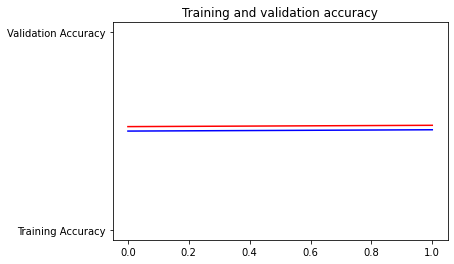

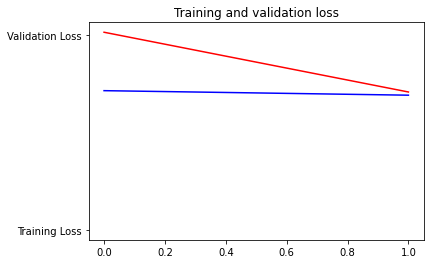

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Getting the number of epochs

# Accuracy Graph
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()
# Loss Graph
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation loss')


